In [1]:
import Dates
println("Last updated: ", Dates.now(), " (PT)")

Last updated: 2020-06-09T15:34:30.203 (PT)


In [2]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [3]:
# Import Libraries
using Turing
using Distributions
using JSON3
using PyPlot
using StatsFuns
import Random
import StatsBase: countmap
include(joinpath(@__DIR__, "../util/BnpUtil.jl"));

In [4]:
# DP GMM model under stick-breaking construction
@time @model dp_gmm_sb(y, K) = begin
    nobs = length(y)

    mu ~ filldist(Normal(0, 3), K)
    sig ~ filldist(Gamma(1, 1/10), K)  # mean = 0.1
    
    alpha ~ Gamma(1, 1/10)  # mean = 0.1
    v ~ filldist(Beta(1, alpha), K - 1)
    eta = BnpUtil.stickbreak(v)

    # NOTE: Slow. And the MCMC gets stuck?
    # y .~ MixtureModel(Normal.(mu, sig), eta)

    # NOTE: Fast, and seems to mix well.
    log_target = logsumexp(normlogpdf.(mu', sig', y) .+ log.(eta)', dims=2)
    Turing.acclogp!(_varinfo, sum(log_target))
end

┌ Warning: you are using the internal variable `_varinfo`
└ @ DynamicPPL /home/ubuntu/.julia/packages/DynamicPPL/h0R38/src/compiler.jl:181


  0.002630 seconds (2.08 k allocations: 126.560 KiB)


DynamicPPL.ModelGen{var"###generator#270",(:y, :K),(),Tuple{}}(##generator#270, NamedTuple())

In [5]:
# Directory where all simulation data are stored.
data_dir = joinpath(@__DIR__, "../../data/sim-data")
path_to_data = joinpath(data_dir, "gmm-data-n200.json")

"/home/ubuntu/repo/TuringBnpBenchmarks/src/dp-gmm/notebooks/../../data/sim-data/gmm-data-n200.json"

In [6]:
# Load data in JSON format.
data = let
    x = open(f -> read(f, String), path_to_data)
    JSON3.read(x, Dict{Symbol, Vector{Any}})
end

Dict{Symbol,Array{Any,1}} with 5 entries:
  :w        => Any[0.204919, 0.195407, 0.194413, 0.222356, 0.182905]
  :mu       => Any[-1.97027, -0.96176, -0.0597634, 0.998955, 1.9161]
  :sig      => Any[0.121097, 0.195192, 0.19999, 0.125166, 0.198667]
  :y        => Any[-1.25496, -1.03452, -1.21095, -1.89215, 0.321395, -1.27175, …
  :rand_idx => Any[2, 2, 2, 1, 3, 2, 5, 5, 2, 5  …  4, 3, 5, 1, 4, 4, 2, 2, 2, …

In [7]:
# Convert data to vector of floats
y = Float64.(data[:y]);

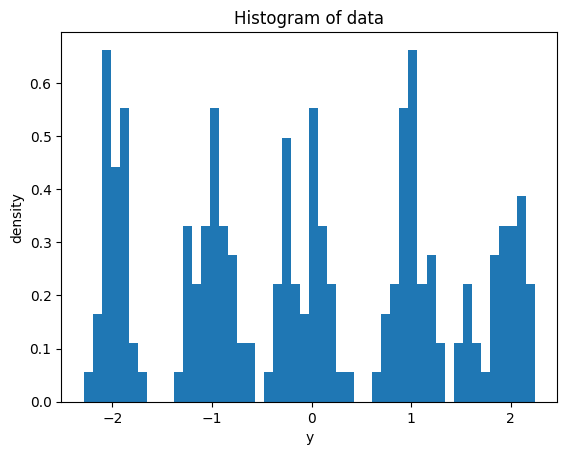

In [8]:
# Visualize data
plt.hist(y, bins=50, density=true)
plt.xlabel("y")
plt.ylabel("density")
plt.title("Histogram of data");

In [9]:
# Fit DP-SB-GMM

# Set random seed for reproducibility
Random.seed!(0);

# NUTS
# Compile time approx. 11s
# Run time approx. 244s
# Slower, but works a little better.
@time chain = begin
    n_components = 10
    n_samples = 500
    nadapt = 500
    iterations = n_samples + nadapt
    burn = 0  # For compatibility with HMC below.
    target_accept_ratio = 0.8
    
    sample(dp_gmm_sb(y, n_components),
           NUTS(nadapt, target_accept_ratio),
           iterations);
end

# HMC
# Compile time approx. 32s.
# Run time approx. 70s.
#
# @time chain = begin
#     burn = 500  # NOTE: The burn in is also returned. Can't be discarded.
#     n_samples = 500
#     iterations = burn + n_samples
#     n_components = 10
#     stepsize = 0.01
#     nleapfrog = floor(Int, 1 / stepsize)
#  
#     sample(dp_gmm_sb(y, n_components), 
#            HMC(stepsize, nleapfrog),
#            iterations)
# end

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/ubuntu/.julia/packages/Turing/d4vqQ/src/inference/hmc.jl:626
Sampling:   1%|▎                                        |  ETA: 0:04:13┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/WJCQA/src/hamiltonian.jl:47
Sampling:   4%|█▊                                       |  ETA: 0:06:59┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/WJCQA/src/hamiltonian.jl:47
Sampling:   6%|██▋                                      |  ETA: 0:07:34┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/WJCQA/src/hamiltoni

352.100706 seconds (181.61 M allocations: 577.577 GiB, 7.79% gc time)


Object of type Chains, with data of type 500×42×1 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = alpha, mu[1], mu[2], mu[3], mu[4], mu[5], mu[6], mu[7], mu[8], mu[9], mu[10], sig[1], sig[2], sig[3], sig[4], sig[5], sig[6], sig[7], sig[8], sig[9], sig[10], v[1], v[2], v[3], v[4], v[5], v[6], v[7], v[8], v[9]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters     mean     std  naive_se    mcse       ess   r_hat
  ──────────  ───────  ──────  ────────  ──────  ────────  ──────
       alpha   0.3663  0.1636    0.0073  0.0222   60.6502  1.0273
       mu[1]   0.9996  0.0280    0.0013  0.0019  260.7748  0.9983
       mu[2]  -0.9859  0.0313    0.0014  0.0013  377.4405  0.9981
       mu[3]  -1.

In [10]:
function extract(chain, sym; burn=0)
    tail  = chain[sym].value.data[(burn + 1):end, :, :]
    return dropdims(tail, dims=3)
end

extract (generic function with 1 method)

In [11]:
vpost = extract(chain, :v, burn=burn);
mupost = extract(chain, :mu, burn=burn);
sigpost = extract(chain, :sig, burn=burn);
etapost = hcat([BnpUtil.stickbreak(vpost[row, :]) for row in 1:size(vpost, 1)]...)';

In [12]:
function plot_param_post(param, param_name, param_full_name; figsize=(10, 4), burn=0)
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.boxplot(param, whis=[2.5, 97.5], showmeans=true, showfliers=false)
    plt.xlabel("mixture components")
    plt.ylabel(param_full_name)
    plt.title("95% Credible Intervals for $(param_full_name)")

    plt.subplot(1, 2, 2)
    plt.plot(param)
    plt.xlabel("iterations")
    plt.ylabel(param_full_name)
    plt.title("Trace plot of $(param_full_name)");
end

plot_param_post (generic function with 1 method)

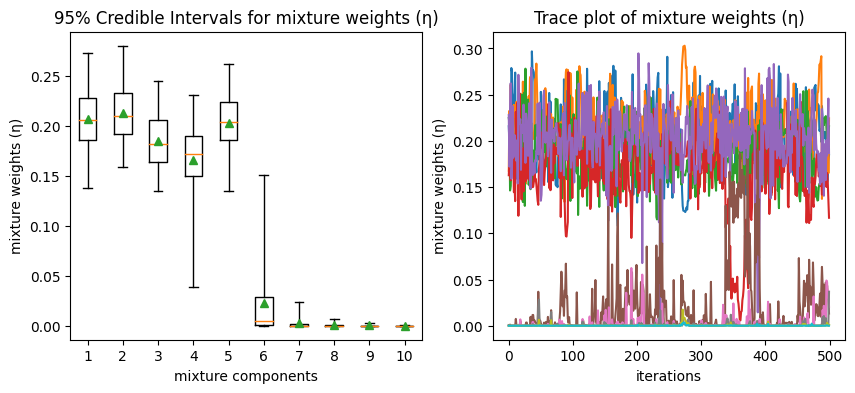

PyObject Text(0.5, 1.0, 'Trace plot of mixture weights (η)')

In [13]:
plot_param_post(etapost, :eta, "mixture weights (η)", burn=burn)

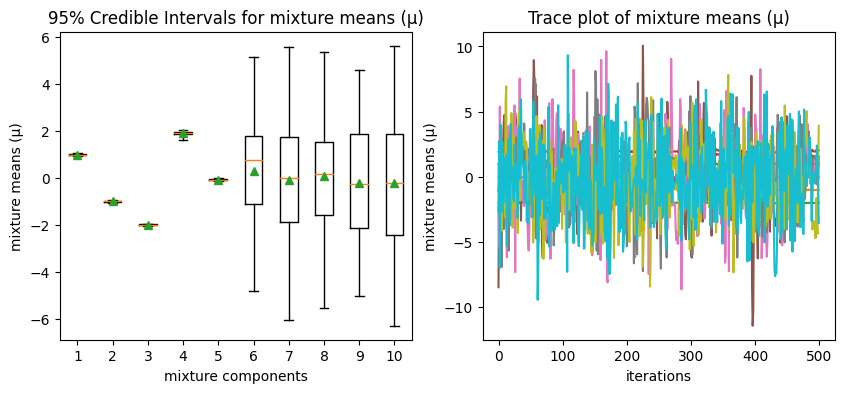

PyObject Text(0.5, 1.0, 'Trace plot of mixture means (μ)')

In [14]:
plot_param_post(mupost, :mu, "mixture means (μ)", burn=burn)

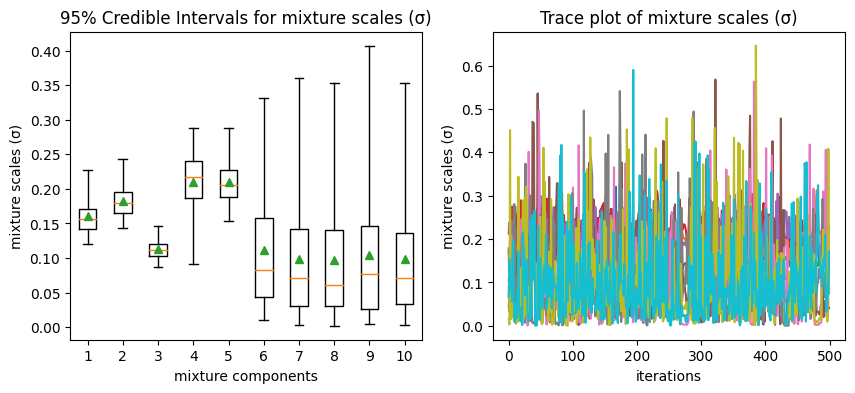

PyObject Text(0.5, 1.0, 'Trace plot of mixture scales (σ)')

In [15]:
plot_param_post(sigpost, :sigma, "mixture scales (σ)", burn=burn)

In [16]:
# TODO: How to get loglikelihood or log posterior?

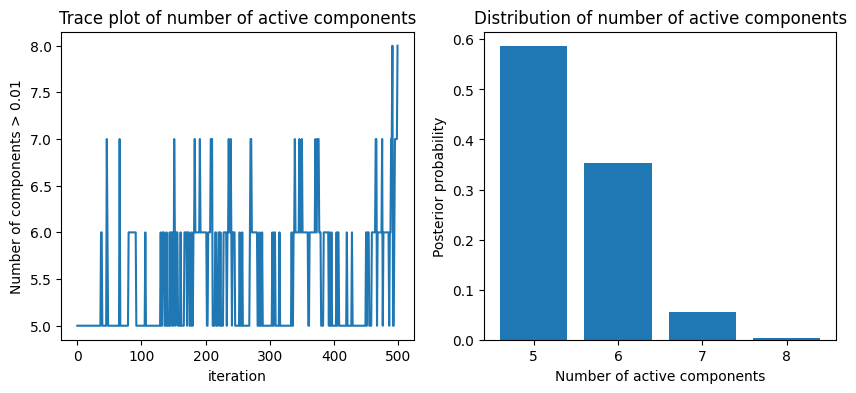

In [17]:
# Plot posterior distribution of number of clusters

# Set a threshold for clusters to be considered as significant.
thresh = 0.01

plt.figure(figsize=(10, 4))

# Trace plot
plt.subplot(1, 2, 1)
plt.plot(sum(etapost .> thresh, dims=2))
plt.xlabel("iteration")
plt.ylabel("Number of components > $thresh")
plt.title("Trace plot of number of active components");

# Bar plot
plt.subplot(1, 2, 2)
ncomponents_post = vec(sum(etapost .> thresh, dims=2))
num_samples = length(ncomponents_post)
countmap_ncomponents = countmap(ncomponents_post)
x_ncomp = Int.(keys(countmap_ncomponents))
y_prop = Int.(values(countmap_ncomponents)) / num_samples
plt.bar(x_ncomp, y_prop)
plt.xlabel("Number of active components")
plt.ylabel("Posterior probability")
plt.title("Distribution of number of active components");

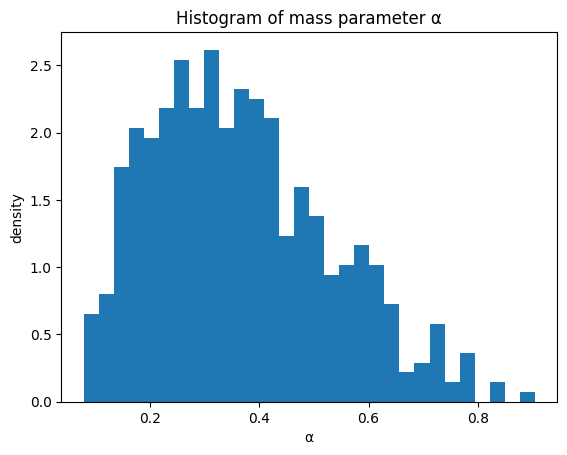

In [18]:
plt.hist(vec(chain[:alpha].value), density=true, bins=30)
plt.xlabel("α")
plt.ylabel("density")
plt.title("Histogram of mass parameter α");